In [24]:
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [20]:
db = {
    "users": {},
    "liked": {},
    "disliked": {}
}

def load_recipes(directory='data/allrecipes/recipes'):
    recipes = []
    file_names = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):
            with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
                content = f.read()
                recipes.append(content)
                file_names.append(file_name)
    return recipes, file_names

recipes, file_names = load_recipes()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(recipes)
print(tfidf_matrix)

  (0, 13516)	0.06237905773963521
  (0, 2937)	0.018111406059540213
  (0, 8936)	0.05919150684818298
  (0, 15751)	0.0235798831506239
  (0, 16341)	0.06186615086718817
  (0, 7321)	0.05099638063026148
  (0, 8550)	0.04290112668668134
  (0, 3053)	0.03806218313525274
  (0, 9494)	0.029383548483780206
  (0, 4656)	0.04479347580324897
  (0, 2904)	0.06237905773963521
  (0, 7852)	0.0703769397574735
  (0, 16751)	0.01900485255890835
  (0, 8193)	0.04197009730298661
  (0, 2845)	0.023874342632050346
  (0, 11178)	0.06469449750734417
  (0, 13199)	0.06679821565183505
  (0, 2570)	0.060451503394460426
  (0, 6871)	0.020972478926810197
  (0, 16561)	0.026784792016567808
  (0, 8273)	0.03061930082690929
  (0, 7587)	0.024291899879021032
  (0, 14943)	0.09004718367427564
  (0, 11054)	0.03189088028002332
  (0, 7082)	0.02197119018442222
  :	:
  (1801, 15534)	0.019504860445106038
  (1801, 10327)	0.013021981975041055
  (1801, 7278)	0.0713163631596032
  (1801, 14517)	0.041028833311643906
  (1801, 15509)	0.09233350815018795

In [31]:

scores = cosine_similarity(tfidf_matrix)
def get_docs(user_id, relevant=True):
    user_likes = db["liked"].get(user_id, [])
    user_dislikes = db["disliked"].get(user_id, [])
    
    if user_likes:
        doc_index = file_names.index(user_likes[0]) 
        similarity_scores = scores[doc_index]
    else:
        similarity_scores = np.mean(scores, axis=0)
    
    relevant_docs = [file_names[idx] for idx in np.argsort(similarity_scores)[::-1]]
    if relevant:
        return relevant_docs
    else:
        return [doc for doc in file_names if doc not in relevant_docs][:10]
def apply_feedback(user_id, doc_id, like=True):
    if like:
        db["liked"].setdefault(user_id, []).append(doc_id)
    else:
        db["disliked"].setdefault(user_id, []).append(doc_id)

def get_cuisine_docs(cuisine_type):
    relevant_docs = [doc for doc in file_names if cuisine_type.lower() in doc.lower()]
    return relevant_docs[:10]

user_id = "user123"
apply_feedback(user_id, "6687.txt", like=True)
print("Recommended docs:", get_docs(user_id))
print("Cuisine-specific docs:", get_cuisine_docs("Italian"))


Recommended docs: ['6687.txt', '16952.txt', '20144.txt', '104999.txt', '241707.txt', '268920.txt', '219967.txt', '41679.txt', '20153.txt', '222082.txt', '7116.txt', '36772.txt', '17066.txt', '141933.txt', '218541.txt', '230482.txt', '220941.txt', '17968.txt', '255621.txt', '9217.txt', '6697.txt', '6820.txt', '239271.txt', '212463.txt', '88506.txt', '6770.txt', '223426.txt', '6934.txt', '232433.txt', '11386.txt', '234854.txt', '232551.txt', '23376.txt', '24142.txt', '6796.txt', '22749.txt', '20334.txt', '6773.txt', '23822.txt', '220494.txt', '256539.txt', '234276.txt', '273495.txt', '6932.txt', '229351.txt', '147988.txt', '219162.txt', '24015.txt', '26061.txt', '281983.txt', '232922.txt', '21014.txt', '17160.txt', '269332.txt', '54165.txt', '277715.txt', '14685.txt', '235874.txt', '279325.txt', '149635.txt', '26317.txt', '18990.txt', '236648.txt', '24035.txt', '13309.txt', '214486.txt', '6845.txt', '9426.txt', '25407.txt', '45396.txt', '245935.txt', '280405.txt', '7016.txt', '19079.txt'

{'241707.txt', '6687.txt', '16952.txt', '20144.txt', '104999.txt'}


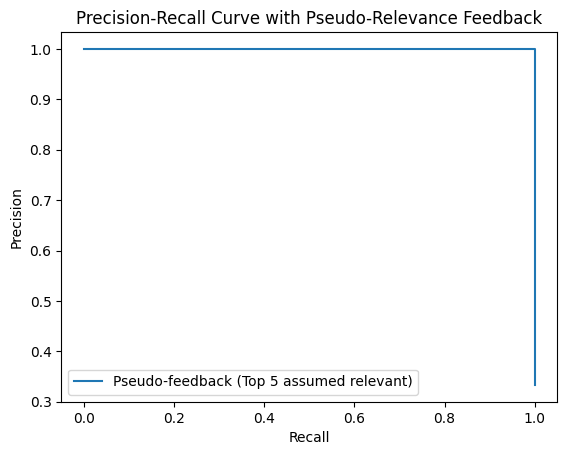

In [34]:
from sklearn.metrics import precision_recall_curve

def pseudo_feedback_precision_recall(user_id, k=5):
    recommended_docs = get_docs(user_id, relevant=True)[:k]
    
    pseudo_relevant_set = set(recommended_docs)
    print(pseudo_relevant_set)
    y_true = [1 if doc in pseudo_relevant_set else 0 for doc in recommended_docs + file_names[:10]]
    y_scores = np.arange(len(recommended_docs) + 10, 0, -1) 

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return precision, recall

precision, recall = pseudo_feedback_precision_recall("user123", k=5)

plt.plot(recall, precision, label="Pseudo-feedback (Top 5 assumed relevant)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Pseudo-Relevance Feedback")
plt.legend()
plt.show()


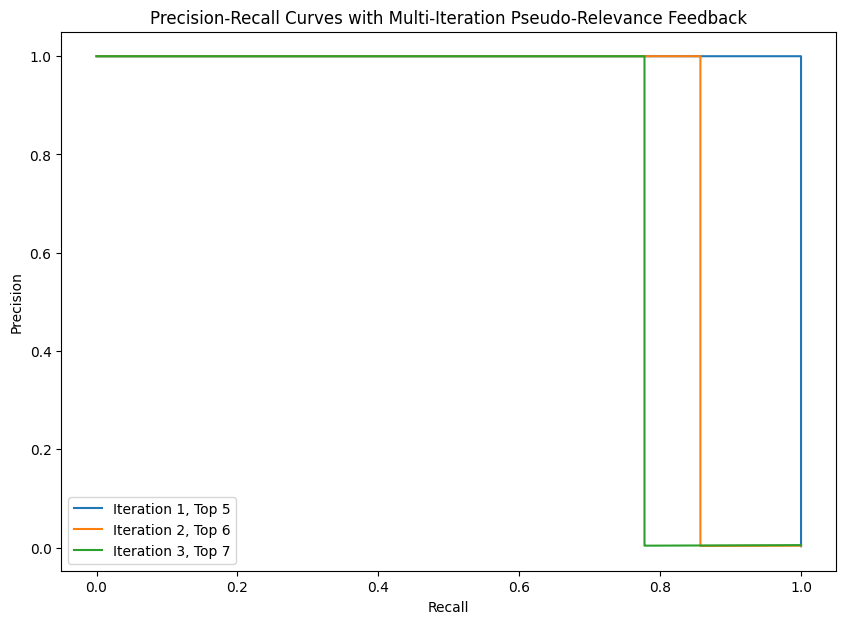

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity

def multi_iteration_pseudo_feedback(user_id, iterations=3, initial_k=5):
    precision_recall_results = {}

    recommended_docs = get_docs(user_id, relevant=True)
    
    for i in range(iterations):
        k = initial_k + i
        pseudo_relevant_set = set(recommended_docs[:k])
        
        y_true = [1 if doc in pseudo_relevant_set else 0 for doc in recommended_docs + file_names[:10]]
        y_scores = np.linspace(len(y_true), 1, len(y_true))

        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        precision_recall_results[f"Iteration {i+1}, Top {k}"] = (precision, recall)
        recommended_docs = sorted(recommended_docs, key=lambda doc: (-int(doc in pseudo_relevant_set), doc))

    plt.figure(figsize=(10, 7))
    for label, (precision, recall) in precision_recall_results.items():
        plt.plot(recall, precision, label=label)
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves with Multi-Iteration Pseudo-Relevance Feedback")
    plt.legend()
    plt.show()

multi_iteration_pseudo_feedback("user123", iterations=3, initial_k=5)


In [27]:
tokenized_recipes = [recipe.lower().split() for recipe in recipes]
word2vec_model = Word2Vec(sentences=tokenized_recipes, vector_size=100, window=5, min_count=1, sg=1)

def generate_recipe_embeddings(recipes):
    embeddings = []
    for recipe in recipes:
        words = recipe.lower().split()
        valid_words = [word for word in words if word in word2vec_model.wv]
        if valid_words:
            recipe_vector = np.mean([word2vec_model.wv[word] for word in valid_words], axis=0)
        else:
            recipe_vector = np.zeros(word2vec_model.vector_size)
        embeddings.append(recipe_vector)
    return np.array(embeddings)

recipe_embeddings = generate_recipe_embeddings(recipes)
scores = cosine_similarity(recipe_embeddings)

In [28]:


def get_docs(user_id, relevant=True):
    user_likes = db["liked"].get(user_id, [])
    
    if user_likes:
        liked_indices = [file_names.index(doc) for doc in user_likes if doc in file_names]
        if liked_indices:
            liked_embeddings = recipe_embeddings[liked_indices]
            similarity_scores = np.mean(cosine_similarity(liked_embeddings, recipe_embeddings), axis=0)
        else:
            similarity_scores = np.mean(scores, axis=0)
    else:
        similarity_scores = np.mean(scores, axis=0)
    
    relevant_docs = [file_names[idx] for idx in np.argsort(similarity_scores)[::-1]]
    if relevant:
        return relevant_docs[:10]  
    else:
        return [doc for doc in file_names if doc not in relevant_docs][:10]  

user_id = "user123"
apply_feedback(user_id, "6687.txt", like=True)
apply_feedback(user_id, "1324.txt", like=True)

recommended_docs = get_docs(user_id)

recommended_docs



['6687.txt',
 '6697.txt',
 '6770.txt',
 '241707.txt',
 '229351.txt',
 '7603.txt',
 '21387.txt',
 '7860.txt',
 '255621.txt',
 '6932.txt']